*Initial note: you might want to view this notebook with [nbviewer](https://nbviewer.jupyter.org/github/zer2/forecasting-speedrun-records/blob/main/Speedrunning%20analysis.ipynb), it is more reliable for showing jupyter notebooks than github*

# Investigating speedrunning world records in python

Speedrunners are video game players who compete with each other to complete games as quickly as possible. The most dedicated are willing to practice almost 24/7 in order to improve world records by even the slimmest of margins. 

A unique dynamic of speedrunning records, which sets them apart from those of similar domains such as physical speed sports, is the importance of innovation. The discovery of glitches or optimizations can transform the landscape of a speedrunning record overnight, cutting records in half or more. The same behavior is simply inconceivable in physical speed sports- there is zero chance that world record for the mile is going to drop from four minutes to two tomorrow. 

This makes the speedrunning world a fertile ground for exploring the dynamics of innovation. We can ask many questions, such as
- Does innovation beget more innovation?
- To what degree can innovation be predicted, and to what degree is it irretrivably chaotic? 

## 1. Setting up 

We will use data from speedrun.com, which conveniently can be obtained via API. The python wrapper for the APi is called 'srcomapi'

In [5]:
import srcomapi, srcomapi.datatypes as dtp
import pandas as pd
import plotly.express as px
import numpy as np
import statsmodels as sm
import statsmodels.api as smapi
from statsmodels.api import OLS
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import warnings
import scipy.stats as st
import plotly.graph_objects as go
from scipy.optimize import curve_fit
import time
import matplotlib.pyplot as plt
import re
import datetime
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter,LogNormalFitter,LogLogisticFitter,ExponentialFitter,CoxPHFitter
from lifelines.plotting import qq_plot
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

Speedrun.com has 'runs' for thousands of games and sub-categories. For now we can pull the 40 games with the most runs, as listed [here](https://www.speedrun.com/games#platform=&orderby=mostruns&unofficial=off)

In [163]:
api = srcomapi.SpeedrunCom(); api.debug = 1

game_names = ["super mario 64","minecraft: java","super mario odyssey","celeste","mario kart 8","portal"
             ,"super metroid","mario sunshine","super mario world","getting over it with bennett foddy"
             ,"roblox: speed run 4","ocarina of time","super mario bros","a link to the past"
             ,"battle for bikini bottom","resident evil 2","minecraft: bedrock","refunct","undertale"
             ,"wii sports resort","outlast","breath of the wild","there is no game","hades"
             ,"roblox: piggy","hollow knight","portal 2","mario kart wii","luigi's mansion"
             ,"the simpsons: hit","grand theft auto v","new super mario bros. wii","super mario bros 3"
             ,"cuphead","sonic adventure 2","resident evil 7","crossy road"
              ,"call of duty: black ops cold war zombies", "pou"]

#seterra removed for now, for having way too many categories

games = [api.search(srcomapi.datatypes.Game, {"name": name})[0] for name in game_names]

https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.speedrun.com/api/v1/games
https://www.

The API will return data as jsons. For our analysis, a dataframe will be more convenient, so we will convert the API results to dataframe as we process them

In [164]:
#future improvement: get names of runners. Right now, accessing the name forces an API call every time, which is 
#bad for performance

#below code based on https://github.com/blha303/srcomapi accessed on 2021-07-04
def add_games(full_df
              ,games):
    '''Adds game data from speedrun.com api to dataframe
    
    Args:
        full_df (df): Dataframe, either empty or with some game data
        games (list): list of game objects

    Returns:
        full_df with rows from additional games
    '''
    
    for game in games: 
        game_df = pd.DataFrame()
        print(game)
        for category in game.categories:
            if category.type == 'per-level':
                #for level categories, we need an extra internal loop
                #the code will throw errors if there is an issue with the data. We want to ignore that and move on
                for level in game.levels:
                    try: 
                        leaderboard = dtp.Leaderboard(
                             api
                             ,data=api.get("leaderboards/{}/level/{}/{}?embed=variables".format(game.id, level.id, category.id))
                                                     )
                        tuples = [get_tuple(run) for run in leaderboard.runs]
                        df = pd.DataFrame(tuples, columns = ['DATE','TIME'])

                        name = category.name + '_' + level.name
                        df.loc[:,'CATEGORY'] = name
                        df.loc[:,'GAME'] = game.name

                        game_df = pd.concat([game_df, df])
                    except Exception as e:
                        print(game.name + ': ' + name)
                        print(e)
                        pass
            else:
                #for other categories, we can grab the leaderboard with one API call
                try:
                    leaderboard = dtp.Leaderboard(
                        api
                        ,data=api.get("leaderboards/{}/category/{}?embed=variables".format(game.id, category.id))
                                                 )
                    tuples = [get_tuple(run) for run in leaderboard.runs]
                    df = pd.DataFrame(tuples, columns = ['DATE','TIME'])
                    df.loc[:,'CATEGORY'] = category.name
                    df.loc[:,'GAME'] = game.name
                    game_df = pd.concat([game_df, df])
                except Exception as e:
                    print(game.name + ': ' + category.name)
                    print(e)
                    pass
                    
        full_df = pd.concat([full_df, game_df])

    return full_df


def get_tuple(run):
    '''Extracts date and time (aka score) from run object with error handling
    This is necessary because list comprehensions cannot handle error handling themselves
    
    Args:
       run  (run object)

    Returns:
        tuple of (date, time)   
    '''
    
    try: date = run['run'].date
    except: date = None
        
    try: time = run['run'].times['primary_t']
    except: time = None
        
    return (date,time)

full_df = pd.DataFrame()
full_df = add_games(full_df, games)

<Game "Super Mario 64">
https://www.speedrun.com/api/v1/games/o1y9wo6q/categories
https://www.speedrun.com/api/v1/games/o1y9wo6q/levels
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/r9gzzkjd/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/o9x22m3w/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/495jjvmw/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/rdq006ow/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/5d7776qd/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/kwjyyo0w/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/owokkgjd/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/xd100vz9/zdnq4oqd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9wo6q/level/ewpppkyw/zdnq4oqd?embed=variables
https://www.speedr

https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/xd1718wd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/z27rpe5d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/xk9ry6xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/zd365jyd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/zd36mqyd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/category/xd1ex5r2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/ywe5zq7w/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/69z2m8g9/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/r9g4k7p9/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/o9x7mxpd/wk67rved?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9j9v6/level/4955vm39/wk67rved?embed=variables
ht

https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/329vkqdv/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/8xd43q9m/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/7xd07mwq/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/4rw6npd7/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/kn9372d0/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/oz986rdl/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/krdn05wm/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/zldyypd3/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/kn9377d0/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/oz9867dl/02qoxl7k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/4pd0n31e/level/

https://www.speedrun.com/api/v1/leaderboards/v1pxjz68/level/495zn29p/wdm6lm3k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/v1pxjz68/level/rdqoqmwx/wdm6lm3k?embed=variables
Super Mario Sunshine: Full Completion_Pianta Village Hoverless
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/v1pxjz68/category/xd14l37d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/v1pxjz68/category/wkpmjjkr?embed=variables
<Game "Super Mario World">
https://www.speedrun.com/api/v1/games/pd0wq31e/categories
https://www.speedrun.com/api/v1/leaderboards/pd0wq31e/category/7kjrn323?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wq31e/category/02qjj79d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wq31e/category/zdn1jxkq?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wq31e/category/n2y1y72o?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0wq31e/category/wkpjpzjk?embed=vari

https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/xd42lxrw/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/xd0q8x49/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/rw6oz3gw/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/n934rozd/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/z987xnpw/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/rdnzyn7d/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/ldygo2rd/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/n934roed/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/z987xnlw/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/rdnzynvd/ndx1mp52?embed=variables
https://www.speedrun.com/api/v1/leaderboards/pd0py36e/level/

https://www.speedrun.com/api/v1/leaderboards/9d3rr0dl/category/ndx9y8rd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/9d3rr0dl/category/n2y180m2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/9d3rr0dl/category/jdz8nmvd?embed=variables
<Game "Battle for Bikini Bottom: Second Strike">
https://www.speedrun.com/api/v1/games/yd4oqqg1/categories
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/category/zd3we4yk?embed=variables
Battle for Bikini Bottom: Second Strike: Any%
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/category/q25g6wyd?embed=variables
Battle for Bikini Bottom: Second Strike: NG+
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/category/9kvoz3j2?embed=variables
Battle for Bikini Bottom: Second Strike: 100%
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/category/9d8

Battle for Bikini Bottom: Second Strike: 100%_Flying Dutchman's Graveyard
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/level/xd140ved/zd3xonnd?embed=variables
Battle for Bikini Bottom: Second Strike: 100%_SpongeBob's Dream
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/level/ewp8p7k9/zd3xonnd?embed=variables
Battle for Bikini Bottom: Second Strike: 100%_Chum Bucket Lab
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/yd4oqqg1/category/824j9zg2?embed=variables
Battle for Bikini Bottom: Second Strike: Cheat%
cannot set a frame with no defined index and a scalar
<Game "Resident Evil 2">
https://www.speedrun.com/api/v1/games/m1zjmz60/categories
https://www.speedrun.com/api/v1/games/m1zjmz60/levels
https://www.speedrun.com/api/v1/leaderboards/m1zjmz60/level/o9xln39l/xk986y20?embed=variables
https://www.speedrun.com/api/

https://www.speedrun.com/api/v1/leaderboards/ldewjld3/category/vdo3459d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/category/q2578g8d?embed=variables
https://www.speedrun.com/api/v1/games/ldewjld3/levels
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/ywe53xqw/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/69z26e69/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/r9g4nqq9/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/o9x7or6d/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/4955zx29/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/rdq7o4m9/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/5d74xq5d/9kvm4p8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/kwjz64r9/9kvm4p8k?embed=variables
https://www.speedr

https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/n934lk7d/ndxmojr2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/level/z9875p7w/ndxmojr2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/category/jdrx490d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/category/zdnxxvn2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/category/wkp1zegk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/ldewjld3/category/7dgnp372?embed=variables
<Game "Outlast">
https://www.speedrun.com/api/v1/games/76r43l18/categories
https://www.speedrun.com/api/v1/leaderboards/76r43l18/category/w20wryod?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/category/vdoor39d?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/category/wkpo8v82?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76r43l18/category/xk986gv2?embed=variables
https://www.speedrun.com/api/v1/l

https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/owo0m6yw/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/49562q2d/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/rdqj8mm9/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/5d7v1j5d/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/kwj5gkr9/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/owo0jmvw/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/xd17mzqd/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/ewpj32lw/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/y9mj6ml9/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/5wkjxm5d/824mrqg2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/

https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/xd4j1z0d/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/xd0g1y0w/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/rw641xn9/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/n9371e7d/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/nwlleq0w/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/ywe1pryd/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/69z30yld/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/r9g28e5d/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/o9xn080w/9d8jg53k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/76rqjqd8/level/4956n30d/9d8jg53k?embed=variables
The Legend of Zelda: Breath of the Wild: 100%_The Divine Tri

https://www.speedrun.com/api/v1/leaderboards/om1mw4d2/level/rdn03l6w/vdooo1vd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mw4d2/level/ldyyq57d/vdooo1vd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mw4d2/level/n937ky2d/vdooo1vd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mw4d2/level/z986pgrd/vdooo1vd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mw4d2/level/29v50ond/vdooo1vd?embed=variables
Portal 2: Single Player_Course 1 - Team Building
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/om1mw4d2/level/xd4reqp9/vdooo1vd?embed=variables
Portal 2: Single Player_Course 2 - Mass and Velocity
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/om1mw4d2/level/xd03nz1d/vdooo1vd?embed=variables
Portal 2: Single Player_Course 3 - Hard-Light Surfaces
cannot set a frame with no defined index and a scalar
https://www.speedrun.co

https://www.speedrun.com/api/v1/leaderboards/o1y9lk6q/category/5dwyj4lk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9lk6q/category/7dg8w5p2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9lk6q/category/824xvrgd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9lk6q/category/02qo17ky?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9lk6q/category/5dwp9elk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9lk6q/category/z27g0og2?embed=variables
https://www.speedrun.com/api/v1/leaderboards/o1y9lk6q/category/zdnw51qd?embed=variables
<Game "The Simpsons: Hit & Run">
https://www.speedrun.com/api/v1/games/m9dok31p/categories
https://www.speedrun.com/api/v1/leaderboards/m9dok31p/category/mndxp12q?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m9dok31p/category/prkleq2n?embed=variables
https://www.speedrun.com/api/v1/leaderboards/m9dok31p/category/7wk6oqk1?embed=variables
https://www.speedrun.com/api/

https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/rdnrl5wm/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/gdrg8ewz/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/592337d6/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/o9xkz3wl/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/ldyj5pd3/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/495kqqm9/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/5d7yjjqd/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/nwlnyodv/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/rdqzmmod/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/495yrmwp/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/

https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/xd0ke509/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/rw6q76nd/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/n93qxj7w/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/ywe2veqw/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/nwlgmjp9/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/69zplg6w/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/gdrp038w/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/r9gymgq9/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/o9x1ye6d/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/xd1jzoqd/zd3qprkn?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/

https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/rdnr25wm/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/ldyj8pd3/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/gdrg1ewz/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/nwlnpodv/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/ywenmlwl/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/69zxnxd1/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/r9gr1jw2/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/o9xk33wl/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/rdqg5o9x/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/495ylmwp/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/

https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/5d7g4gdy/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/owor6ow6/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/kwj2zn9g/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/o9xxq119/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/495mgkjw/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/level/rdqnrz1d/xd1mrrrd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/category/9d8vge6k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/category/q253qm8k?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/category/wk6jj7qd?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/category/zdn0mp72?embed=variables
https://www.speedrun.com/api/v1/leaderboards/om1mx362/category/q25g0wwd?embed=variab

https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/29v353xw/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/xd4jrj8d/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/xd0g3gjw/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/rw64e469/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/n937y7rd/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/z986g61d/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/rdn0206w/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/ldyy8y7d/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/69z3n2xd/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/level/r9g214jd/9d86pe32?embed=variables
https://www.speedrun.com/api/v1/leaderboards/w6jmm26j/catego

Sonic Adventure 2: Battle: Mission 2_Aquatic Mine
'data'
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/ywe10k7d/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/rdqjy229/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/ewpj3kjw/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/xd4j1vrd/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/rdn07k7w/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/69z35mgd/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/5d7v1y6d/7dgr95xk?embed=variables
Sonic Adventure 2: Battle: Mission 2_Crazy Gadget
'data'
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/y9mj65x9/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/xd0g1k4w/7dgr95xk?embed=variables
https://www.speedrun.com/api/v1/leaderbo

https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/owo0jkyw/mkezrjxk?embed=variables
Sonic Adventure 2: Battle: Mission 3_Egg Quarters
'data'
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/592zkjr9/mkezrjxk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/n93710ed/mkezrjxk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/nwll56rw/mkezrjxk?embed=variables
Sonic Adventure 2: Battle: Mission 3_Security Hall
'data'
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/495628jd/mkezrjxk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/xd17m56d/mkezrjxk?embed=variables
Sonic Adventure 2: Battle: Mission 3_Route 280
'data'
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/29v36knw/mkezrjxk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/z98638ld/mkezrjxk?embed=variables
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/ywe1y8rd/mkezrjxk?e

Sonic Adventure 2: Battle: Mission 4_Green Hill
'data'
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/5wkjxjqd/5dw58ynd?embed=variables
Sonic Adventure 2: Battle: Mission 4_Eggman 1
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/592zkzr9/5dw58ynd?embed=variables
Sonic Adventure 2: Battle: Mission 4_Shadow 1
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/29v363nw/5dw58ynd?embed=variables
Sonic Adventure 2: Battle: Mission 4_King Boom Boo
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/xd4j1jpd/5dw58ynd?embed=variables
Sonic Adventure 2: Battle: Mission 4_Egg Golem (Hero)
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/xd0g1g1w/5dw58ynd?embed=variables
Sonic Adventure 2: Battle: Mission 4_Rouge
cannot set a frame 

Sonic Adventure 2: Battle: Mission 5_Shadow 2
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/z98636ld/wk67o1rd?embed=variables
Sonic Adventure 2: Battle: Mission 5_Hot Shot
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/rdn070vw/wk67o1rd?embed=variables
Sonic Adventure 2: Battle: Mission 5_Hot Shot
'data'
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/ldyyxyzd/wk67o1rd?embed=variables
Sonic Adventure 2: Battle: Mission 5_Flying Dog
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/gdrenez9/wk67o1rd?embed=variables
Sonic Adventure 2: Battle: Mission 5_Sonic 1
cannot set a frame with no defined index and a scalar
https://www.speedrun.com/api/v1/leaderboards/l3dx0vdy/level/nwll5lrw/wk67o1rd?embed=variables
Sonic Adventure 2: Battle: Mission 5_Sonic 1
'data'
https://www.speedrun.com

In [165]:
full_df.head()

,DATE,TIME,CATEGORY,GAME
0,2019-05-11,373.97,Stage RTA_Bob-omb Battlefield,Super Mario 64
1,2017-02-17,374.33,Stage RTA_Bob-omb Battlefield,Super Mario 64
2,2018-01-25,376.57,Stage RTA_Bob-omb Battlefield,Super Mario 64
3,2016-11-21,376.67,Stage RTA_Bob-omb Battlefield,Super Mario 64
4,2017-08-15,378.91,Stage RTA_Bob-omb Battlefield,Super Mario 64


## 2.  Exploratory data analysis

Let's transform the data to show what we are most interested in- record-breaking runs. At the same time, we will keep track of interesting metrics to analyze later

In [166]:
def feature_engineering(df, category_threshold = 50):
    '''Takes raw dataframe of game data and transforms to record-based dataframe with features
    
    Args:
       df (df): Dataframe with game data
       category_threshold (int): number of runs needed to count category

    Returns:
        Dataframe with record data  
    '''
    
    #the df is sorted by time so that if there are multiple records broken on the same day, only the best/lowest will count
    #this is the only way to resolve multiple records on the same day, because we don't know how many were real record
    #breaks without knowing the time they were submitted
    full_df_processed = df.dropna().sort_values(['GAME','CATEGORY','DATE','TIME']).copy()

    #adding features based on all runs, not just records
    full_df_processed.loc[:,'CURRENT_RECORD'] = full_df_processed.groupby(['CATEGORY'])['TIME'].cummin()
    full_df_processed.loc[:,'PREVIOUS_RECORD'] = full_df_processed.groupby(['CATEGORY','GAME'])['CURRENT_RECORD'].shift(1)

    full_df_processed.loc[:,'CUMULATIVE_RUNS'] = full_df_processed.groupby(['GAME','CATEGORY']).cumcount()
    full_df_processed.loc[:,'FUTURE_RUNS'] = full_df_processed.groupby(['GAME','CATEGORY']).cumcount(ascending = False)

    full_df_processed.loc[:,'RECORD_FLAG'] = full_df_processed['TIME'] < full_df_processed['PREVIOUS_RECORD']

    #picking out only records from frequently played categories- smaller ones might have odd behavier
    category_counts  = full_df_processed.groupby(['GAME','CATEGORY'], as_index = False)['TIME'].count()
    large_categories = category_counts.loc[category_counts['TIME'] > category_threshold, ['GAME','CATEGORY']]
    full_df_processed_large_categories = full_df_processed.merge(large_categories)
    records = full_df_processed_large_categories[full_df_processed_large_categories['RECORD_FLAG']].copy()
    
    #number of days that the record stood, or is standing
    records.loc[:,'AFTER_DATE'] = records.groupby(['GAME','CATEGORY'])['DATE'].shift(-1)
    records.loc[:,'IS_STANDING'] = records['AFTER_DATE'] != records['AFTER_DATE']
    records.loc[:,'AFTER_DATE'] = records['AFTER_DATE'].fillna(datetime.datetime.today())
    records.loc[:,'DAYS_STANDING'] = (pd.to_datetime(records['AFTER_DATE']) - pd.to_datetime(records['DATE'])).dt.days
    records.loc[:,'PREVIOUS_DAYS_STANDING'] = records.groupby(['GAME','CATEGORY'])['DAYS_STANDING'].shift(1)

    #percentage improvement against previous record
    records.loc[:,'PREVIOUS_TIME'] = records.groupby(['GAME','CATEGORY'])['TIME'].shift(1)
    records.loc[:,'RATIO_CUT'] = (1 - records['TIME']/records['PREVIOUS_TIME'])

    #number of runs required to reach the record
    records.loc[:,'PREVIOUS_CUMULATIVE_RUNS'] = records.groupby(['GAME','CATEGORY'])['CUMULATIVE_RUNS'].shift(1)
    records.loc[:,'AFTER_CUMULATIVE_RUNS'] = records.groupby(['GAME','CATEGORY'])['CUMULATIVE_RUNS'].shift(-1)
    records.loc[:,'RUNS_SINCE_LAST'] = records['CUMULATIVE_RUNS'] - records['PREVIOUS_CUMULATIVE_RUNS']

    #number of runs for which the record stood, or is standing 
    records.loc[:,'RUNS_STANDING'] = (records['AFTER_CUMULATIVE_RUNS'] - records['CUMULATIVE_RUNS']).fillna(records['FUTURE_RUNS'])
    records.loc[:,'PREVIOUS_RUNS_STANDING'] = records.groupby(['GAME','CATEGORY'])['RUNS_STANDING'].shift(1)

    #get days since first record
    records.loc[:,'DATE_FIRST_RECORD'] = records.groupby(['GAME','CATEGORY'])['DATE'].transform('first')
    records.loc[:,'DAYS_SINCE_FIRST_RECORD'] = (pd.to_datetime(records['DATE']) - pd.to_datetime(records['DATE_FIRST_RECORD'])).dt.days

    return records

records = feature_engineering(full_df)
records.head()

,DATE,TIME,CATEGORY,GAME,CURRENT_RECORD,PREVIOUS_RECORD,CUMULATIVE_RUNS,FUTURE_RUNS,RECORD_FLAG,AFTER_DATE,...,PREVIOUS_DAYS_STANDING,PREVIOUS_TIME,RATIO_CUT,PREVIOUS_CUMULATIVE_RUNS,AFTER_CUMULATIVE_RUNS,RUNS_SINCE_LAST,RUNS_STANDING,PREVIOUS_RUNS_STANDING,DATE_FIRST_RECORD,DAYS_SINCE_FIRST_RECORD
4,2020-11-14,125.000,Die Maschine,Call of Duty: Black Ops Cold War Zombies,125.000,144.220,4,974,True,2020-11-15,...,NaN,NaN,NaN,NaN,29.0,NaN,25.0,NaN,2020-11-14,0
29,2020-11-15,117.000,Die Maschine,Call of Duty: Black Ops Cold War Zombies,117.000,125.000,29,949,True,2020-11-16,...,1.0,125.000,0.064000,4.0,65.0,25.0,36.0,25.0,2020-11-14,1
65,2020-11-16,108.460,Die Maschine,Call of Duty: Black Ops Cold War Zombies,108.460,117.000,65,913,True,2020-11-17,...,1.0,117.000,0.072991,29.0,103.0,36.0,38.0,36.0,2020-11-14,2
103,2020-11-17,107.293,Die Maschine,Call of Duty: Black Ops Cold War Zombies,107.293,108.460,103,875,True,2020-11-18,...,1.0,108.460,0.010760,65.0,148.0,38.0,45.0,38.0,2020-11-14,3
148,2020-11-18,96.267,Die Maschine,Call of Duty: Black Ops Cold War Zombies,96.267,107.293,148,830,True,2020-11-19,...,1.0,107.293,0.102765,103.0,192.0,45.0,44.0,45.0,2020-11-14,4


We filtered for categories with a sizeable number of runs, defined for now as 50 or more. So with that constraint, what games/categories remain?

In [167]:
series = records[['GAME','CATEGORY']].drop_duplicates().sort_values('GAME').reset_index().drop(columns = 'index')
print(series.shape[0])

222


That is a good number!

Let's inspect the world record progressions graphically. We can specify which series by using the row number of the table above

In [168]:
i = 67

game_name = series.loc[i,'GAME']
category_name = series.loc[i,'CATEGORY']

plot_df = records[(records['CATEGORY'] == category_name) & (records['GAME'] == game_name)].copy()
#plotly requires datetimes to display in HH:MM:SS format, so we add seconds to a dummy date 
plot_df.loc[:,'TIME'] = [pd.Timestamp('2017-01-01') + pd.DateOffset(seconds = x) for x in plot_df['TIME']]

fig = px.line(plot_df
              , x="DATE"
              , y="TIME"
              , title=game_name + ', ' + category_name + ' world record progression'
              )

fig.update_yaxes(
    tickformat="%H:%M:%S")

fig.show()

Obviously world records go down over time. It is also not surprising that the rate of decrease tends to drop off over time- as the low-hanging fruit is discovered or optimized, it gets harder to push down the record further

We can begin our inspection of other quantities of interest by plotting their histograms. The two that we are most interested in are 
- RATIO_CUT: the magnitude of individual record changes, as a percentage of the previous record
- DAYS_STANDING: how many days a record has stood without being beaten

In [169]:
px.histogram(records, x="RATIO_CUT")

In [170]:
px.histogram(records, x="DAYS_STANDING")

We can also look at how these two compare to each other via scatterplot. While we are at it, we might as well also check how they vary over time (DAYS_SINCE_FIRST_RECORD)

In [171]:
fig = px.scatter_matrix(records[['DAYS_STANDING','DAYS_SINCE_FIRST_RECORD','RATIO_CUT']])
fig.show()

RATIO_CUT seems like it is inversely correlated to both DAYS_STANDING and DAYS_SINCE_FIRST_RECORD. This relationship might be important

## 3 Describing the RATIO_CUT distribution

Some properties of RATIO_CUT are obvious upon inspection. To go further, we can fit RATIO_CUT to all the common distributions supported by scipy, and see which matches it most closely

In [172]:
#below function is adapted from https://gist.github.com/MuLx10/5c39dbe5718dcff8ad5e744347548545
def best_fit_distribution(data
                          ,bins=200):
    '''Model data by finding best fit distribution to data
    
    Args:
       data (series): series of data for which to fit a distribution
       bins (int): number of bins for histogram, used in fitting 

    Returns:
        Dataframe with record data  
    '''
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #levy_stable hangs on fitting
    DISTRIBUTIONS = [getattr(st, d) for d in dir(st) 
                     if (isinstance(getattr(st, d), st.rv_continuous) & (d != 'levy_stable'))]
    
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)
                
                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist
             ,params
             ,size=10000):
    '''Generate distributions's Probability Distribution Function
    
    Args:
       dist (scipy distribution): type of distribution
       params (tuple): parameters of distribution
       size (int): size of pdf to generate

    Returns:
        Series mapping values to probability density
    '''
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


In [203]:
# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(records['RATIO_CUT'].dropna(), bins = 100)
best_dist = getattr(st, best_fit_name)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)
pdf.name = 'Theoretical distribution'

fig = go.Figure()
fig = px.line(pdf)
fig.add_trace(go.Histogram(x = records['RATIO_CUT']
                           , xbins = dict( # bins used for histogram
                                        start=0.0,
                                        end=0.3,
                                        size=0.002
                                          )
                           , histnorm = 'probability density'
                            ,name = 'Observed values'
                          )
             )

fig.update_layout(
    title="Matching RATIO_CUT to " + best_fit_name + ' distribution',
    xaxis_title="RATIO_CUT",
    yaxis_title="Frequency",
    legend_title="Legend"
)

fig.show()

The code chose powerlognorm as the best-fitting distribution. Just looking at the histogram, it appears to fit the empiral data quite closely

powerlognorm has a potentially useful property, which is that it is a generalization of the log-normal distribution. This suggests that if we take the logarithm, it could be close to a normal distribution (that is important because regressions work well on data with normally distributed errors). We can try to build a simple linear model for RATIO_CUT, and see if the residuals are distributed roughly normally 

In [174]:
def train_cut_model(records):
    '''Train linear model to predict RATIO_CUT
    
    Args:
       records (df): data to train on

    Returns:
        Linear model
    '''
    for_training = records[records['RATIO_CUT'] == records['RATIO_CUT']].copy()
    for_training.loc[:,'FIRST_FIVE_DAYS'] = (for_training['DAYS_SINCE_FIRST_RECORD'] <= 5).astype(float)
    for_training['DAYS_SINCE_FIRST_RECORD'] = np.log(for_training['DAYS_SINCE_FIRST_RECORD'] + 5)

    cut_model = OLS(np.log(for_training['RATIO_CUT'])
                    , for_training[['DAYS_SINCE_FIRST_RECORD','FIRST_FIVE_DAYS']]
                            ).fit()
    return cut_model

def get_cut_distributions(standing_records, cut_model):
    '''Train linear model to predict RATIO_CUT
    
    Args:
       standing_records (df): records to produce estimates for
       cut model (linear model)

    Returns:
        Predictions of the logarithm of RATIO_CUT, and a standard deviation 
    '''
    for_testing = standing_records.copy()
    
    for_testing.loc[:,'FIRST_FIVE_DAYS'] = (for_testing['DAYS_SINCE_FIRST_RECORD'] <= 5).astype(float)
    for_testing['DAYS_SINCE_FIRST_RECORD'] = np.log(for_testing['DAYS_SINCE_FIRST_RECORD'] + 5)    
    
    log_predictions = cut_model.predict(for_testing[['DAYS_SINCE_FIRST_RECORD','FIRST_FIVE_DAYS']])
    standard_deviation = np.sqrt(cut_model.scale)

    return log_predictions, standard_deviation

In [175]:
cut_model = train_cut_model(records)
cut_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              RATIO_CUT   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                              5084.
Date:                Thu, 22 Jul 2021   Prob (F-statistic):                        0.00
Time:                        00:15:31   Log-Likelihood:                         -3073.1
No. Observations:                1650   AIC:                                      6150.
Df Residuals:                    1648   BIC:                                      6161.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
DAYS_SINCE_FIRST_RECORD    -0.6312      0.006    -99.866      0.000      -0.644      -0.619
FIRST_FIVE_DAYS            -1.3907      0.192     -7.230      0.000      -1.768      -1.013
==============================================================================
Omnibus:                       41.247   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.232
Skew:                          -0.373   Prob(JB):                     2.48e-10
Kurtosis:                       3.294   Cond. No.                         30.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The skewness is close to 0 and the kurtosis is close to 3, so we are safe to say that the errors are roughly normally distributed. That is good news for our linear model. We can also check residuals against our scalar variable DAYS_SINCE_FIRST_RECORD, to make sure they appear independent

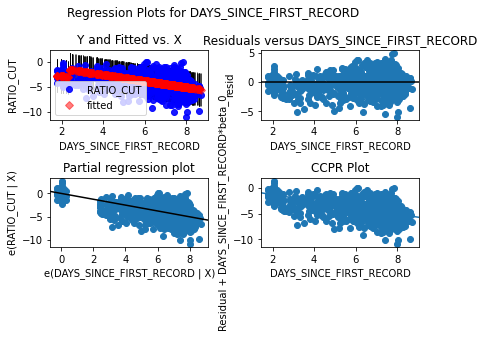

In [130]:
fig =  smapi.graphics.plot_regress_exog(cut_model, "DAYS_SINCE_FIRST_RECORD")
fig.tight_layout(pad=1.0)

The residuals look reasonably independent, which is good

Looking back at the summary, the r^2 is high, and the p-values are low, suggesting that DAYS_SINCE_FIRST_RECORD and FIRST_FIVE_DAYS have a significent effect on RATIO_CUT. One thing to note is that the Durbin Watson score is significantly below 2, suggesting some amount of autocorrelation. This does not have a definite statistical interpretation because the data is unordered, and switching the order arbitrarily would change the score. However it does provide an indication that game/category also affect RATIO_CUT since the data is clumped by game/category

We don't need it now, but we also wrote a get_cut_distributions function which uses the linear model to produce distributions on new data

## 4. Describing the record risk function, by time

Unfortunately, we cannot repeat the above process to fit a distribution for DAYS_STANDING. The problem is that the dataset is biased: all of the standing records are cut off, and we don't know how long they will continue to stand.

The solution to this dilemma is to apply survival analysis. Survival analysis is a branch of statistics which deals with "censored" time-to-event data. One of its most-used methods is Kaplan Meier fitting, which estimates a distribution for how long it will take for an event to happen. We can apply it to our DAYS_STANDING column, using IS_STANDING to determine which records have not yet been broken

<AxesSubplot:xlabel='timeline'>

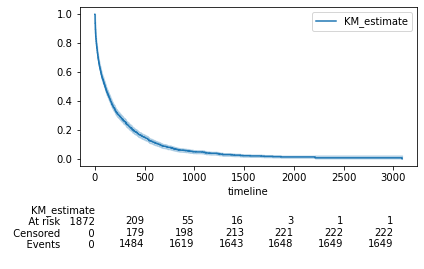

In [176]:
kmf = KaplanMeierFitter()
kmf_fit = kmf.fit(records['DAYS_STANDING'],event_observed = ~records['IS_STANDING'])
kmf.plot(at_risk_counts=True)

That is the overall survival curve for records we have looked at. We can make some observations: e.g. after one year, about 25% of records are left standing

We can also break the analysis down by game

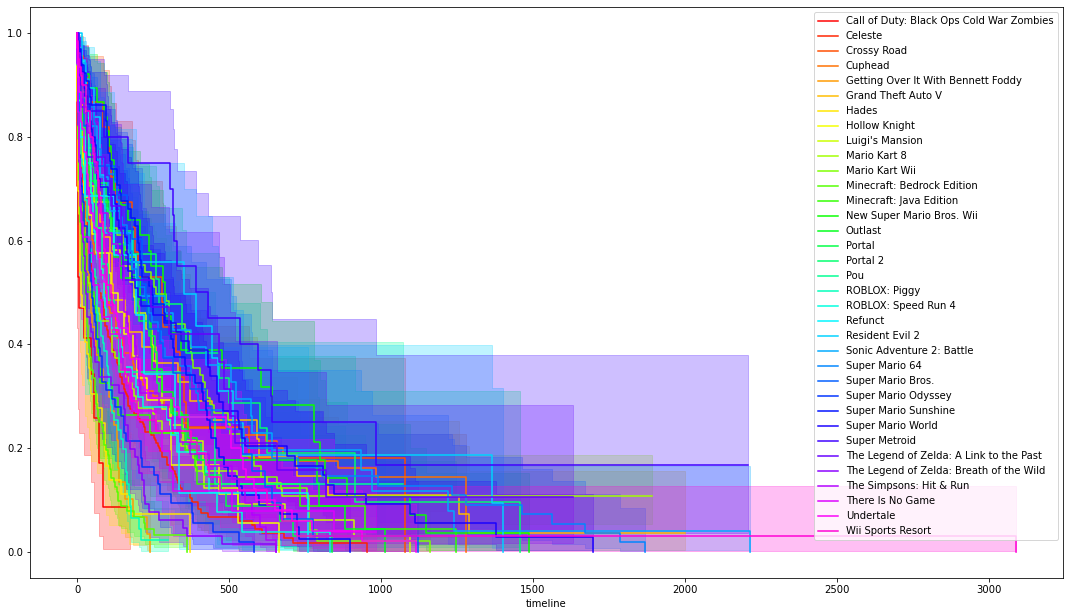

In [222]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

cm = plt.get_cmap('hsv')
ax.set_prop_cycle(color = [cm(1.*i/len(games)) for i in range(len(games))])

for game in records['GAME'].unique():
    
    flag = records['GAME'] == game
    
    kmf.fit(records['DAYS_STANDING'][flag]
            ,event_observed = ~records['IS_STANDING'][flag]
        , label=game)
    kmf.plot(ax=ax)

Clearly some games have records broken more rapidly than others. Also, it is hard to tell from the chart, but the game with the longest-lasting records is apparently Super Metriod

We can also try parametric models, to see if any simple distributions can fit the data well. To see which parametric model is most applicable to this data, we look at QQ plots

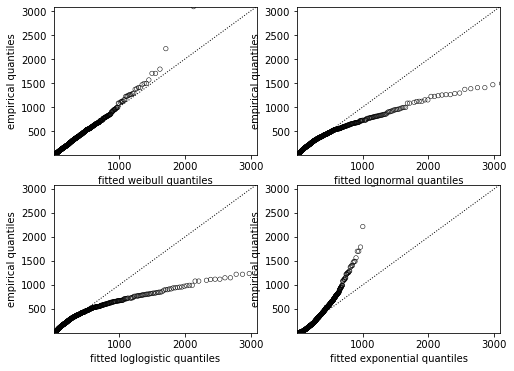

In [178]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(records['DAYS_STANDING'] + 1,event_observed = ~records['IS_STANDING'])
    qq_plot(model, ax=axes[i])

Clearly Weibull is the most appropriate parametric model, even if there is some discrepancy at the tail

<AxesSubplot:>

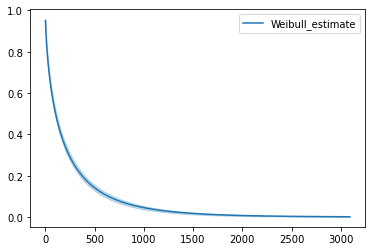

In [209]:
from lifelines import WeibullFitter
from lifelines.plotting import qq_plot

wbf = WeibullFitter()
wbf_fit = wbf.fit(records['DAYS_STANDING'] + 1,event_observed = ~records['IS_STANDING'])
wbf.plot_survival_function()

We can also make break down the games separately with the Weibull distribution

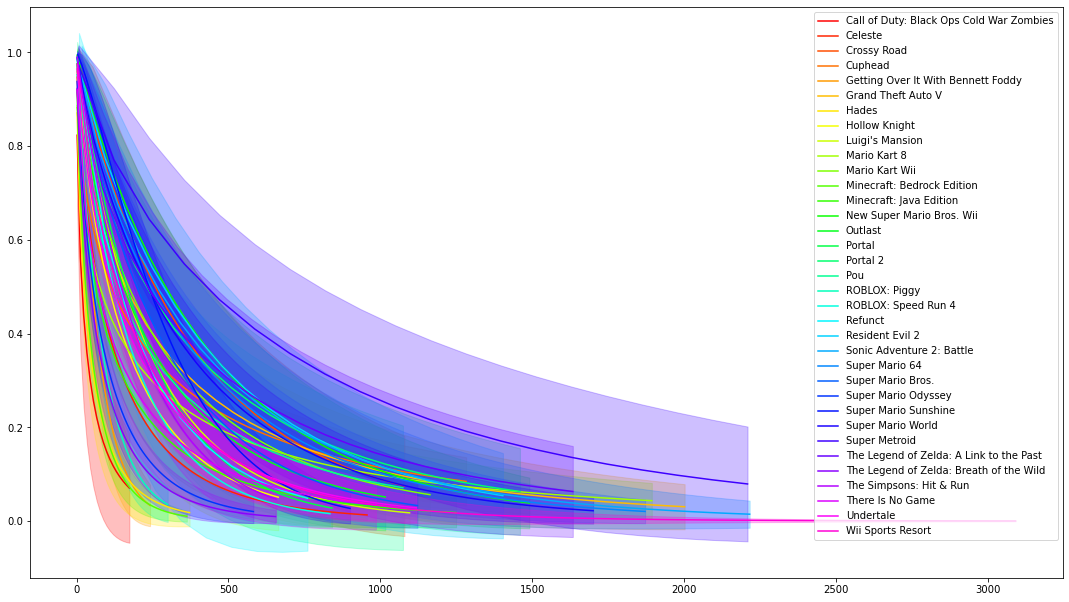

In [218]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5, forward=True)

cm = plt.get_cmap('hsv')
ax.set_prop_cycle(color = [cm(1.*i/len(games)) for i in range(len(games))])

for game in records['GAME'].unique():
    
    flag = records['GAME'] == game
    
    wbf.fit(records['DAYS_STANDING'][flag] + 1
            ,event_observed = ~records['IS_STANDING'][flag]
        , label=game)
    wbf.plot_survival_function(ax=ax)


Unsurprisingly, these results are similar to those from Kaplan Meier

One question we might ask: are larger record-breaks more or less likely to be broken quickly? We can approach that with a cox regression model, which is non-parametric but allows external regressors

In [181]:
def fit_time_cox(records):
    '''Does some data engineering, and fits survival model
    
    Args:
       records (df): data to train on

    Returns:
        Survival model, feature list, engineered records
    '''
    subsequent_records = records[records['RATIO_CUT'] == records['RATIO_CUT']].copy()
    subsequent_records.loc[:,'NOT_STANDING'] = ~subsequent_records['IS_STANDING']
    games = subsequent_records['GAME']
    subsequent_records = pd.get_dummies(subsequent_records, columns = ['GAME'], drop_first = True)
    subsequent_records.loc[:,'GAME'] = games

    subsequent_records.loc[:,'PREVIOUS_DAYS_STANDING_LOG'] = np.log(subsequent_records['PREVIOUS_DAYS_STANDING'] + 1)
    subsequent_records.loc[:,'DAYS_SINCE_FIRST_RECORD_LOG'] = np.log(subsequent_records['DAYS_SINCE_FIRST_RECORD'] + 1)
    
    subsequent_records.loc[:,'PREVIOUS_RUNS_STANDING_LOG'] = np.log(subsequent_records['PREVIOUS_RUNS_STANDING'] + 1)
    subsequent_records.loc[:,'CUMULATIVE_RUNS_LOG'] = np.log(subsequent_records['CUMULATIVE_RUNS'] + 1)

    features = ['PREVIOUS_DAYS_STANDING_LOG','DAYS_SINCE_FIRST_RECORD_LOG','PREVIOUS_RUNS_STANDING_LOG','CUMULATIVE_RUNS_LOG'] + \
                [col for col in subsequent_records.columns if (re.match('GAME_', col))]

    cph = CoxPHFitter()
    cph.fit(subsequent_records[['DAYS_STANDING','NOT_STANDING'] + features]
                ,duration_col = 'DAYS_STANDING'
                ,event_col = 'NOT_STANDING')
    return cph, features, subsequent_records

cph, cox_features, subsequent_records = fit_time_cox(records)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1650 total observations, 218 right-censored observations>
             duration col = 'DAYS_STANDING'
                event col = 'NOT_STANDING'
      baseline estimation = breslow
   number of observations = 1650
number of events observed = 1432
   partial log-likelihood = -9058.72
         time fit was run = 2021-07-22 04:16:40 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
PREVIOUS_DAYS_STANDING_LOG                    -0.16       0.85       0.04            -0.23            -0.09                 0.79                 0.91
DAYS_SINCE_FIRST_RECORD_LOG                   -0.14       0.87       0.03            -0.21            -0.08                 0.81                 0.93
PREVIOUS_RUNS_STANDING_LOG                     0.27       1.31       0.05             0.17             0.37                 1.18                 1.45
CUMULATIVE_RUNS_LOG                           -0.09       0.91       0.05            -0.19             0.01                 0.82                 1.01
GAME_Celeste                                   0.10       1.10       0.33            -0.54             0.73                 0.58                 2.08
GAME_Crossy Road                              -0.77       0.46       0.42            -1.60             0.06                 0.20                 1.06
GAME_Cuphead                                  -0.67       0.51       0.34            -1.33            -0.00                 0.26                 1.00
GAME_Getting Over It With Bennett Foddy        0.56       1.75       0.35            -0.13             1.25                 0.88                 3.50
GAME_Grand Theft Auto V                       -0.03       0.97       0.38            -0.78             0.71                 0.46                 2.03
GAME_Hades                                     0.48       1.61       0.35            -0.21             1.17                 0.81                 3.22
GAME_Hollow Knight                             0.01       1.01       0.39            -0.76             0.78                 0.47                 2.17
GAME_Luigi's Mansion                           0.09       1.10       0.37            -0.64             0.82                 0.53                 2.28
GAME_Mario Kart 8                             -0.31       0.73       0.34            -0.98             0.36                 0.37                 1.44
GAME_Mario Kart Wii                           -0.49       0.61       0.35            -1.16             0.19                 0.31                 1.21
GAME_Minecraft: Bedrock Edition                0.65       1.92       0.33             0.01             1.30                 1.01                 3.66
GAME_Minecraft: Java Edition                   0.44       1.55       0.37            -0.28             1.16                 0.76                 3.19
GAME_New Super Mario Bros. Wii                -0.74       0.48       0.38            -1.48             0.00                 0.23                 1.00
GAME_Outlast                                  -0.22       0.81       0.39            -0.98             0.54                 0.38                 1.72
GAME_Portal                                    0.01       1.01       0.37            -0.71             0.73                 0.49                 2.07
GAME_Portal 2                                 -0.61       0.54       0.41            -1.41             0.19                 0.24                 1.21
GAME_Pou                                       0.38       1.47       0.45            -0.50             1.27                 0.61                 3.56
GAME_ROBLOX: Piggy                             0.16       1.17       0.34            -0.50             0.82                 0.60                 2.28
GAME_ROBLOX: Speed Run 

The concordance score of 0.66 is reasonably good- anything about 0.5 is better than random. You can read more about concordance score [here](https://medium.com/analytics-vidhya/concordance-index-72298c11eac7#:~:text=The%20concordance%20index%20or%20c,number%20of%20possible%20evaluation%20pairs.&text=In%20that%20case%2C%20the%20concordance,to%20its%20maximum%20value%201.)

Some notes based on the summary:
- PREVIOUS_DAYS_STANDING appears to be have a significant (though slight) damping effect on risk: that is, when records are being broken quickly, they are likely to continue being broken
- DAYS_SINCE_FIRST_RECORD has an even larger effect than PREVIOUS_DAYS_STANDING, suggesting that records stick around longer in older categories

## 5. Describing risk in terms of runs

Another option we have is to ignore time altogether, and think of runs as the operative time-like characteristic

<AxesSubplot:xlabel='timeline'>

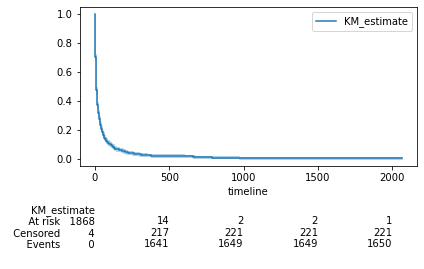

In [182]:
kmf = KaplanMeierFitter()
kmf_fit = kmf.fit(records['RUNS_STANDING'],event_observed = ~records['IS_STANDING'])
kmf.plot(at_risk_counts=True)

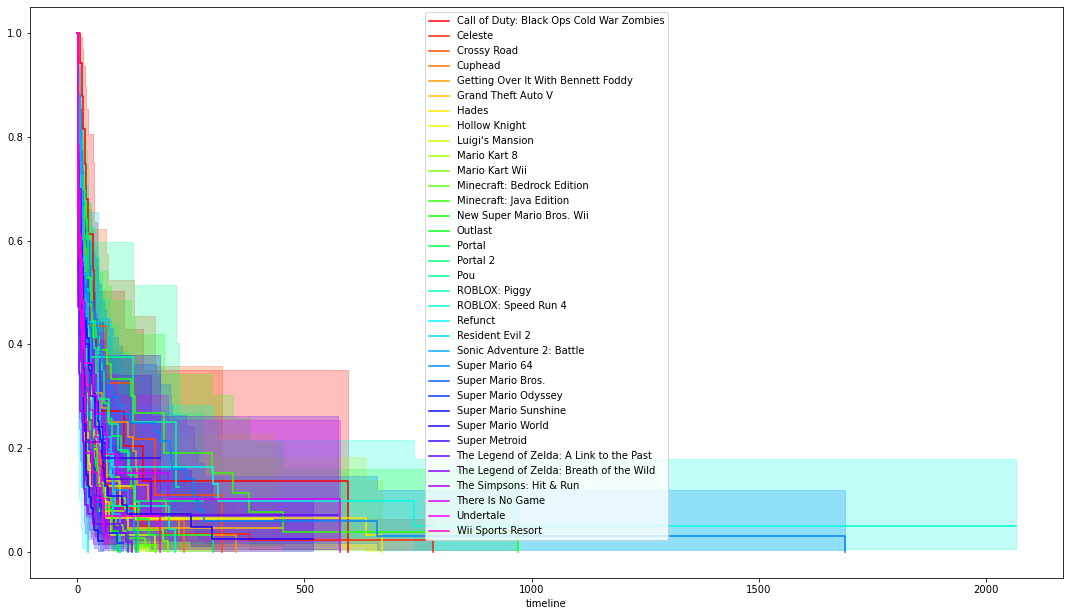

In [219]:
fig, ax = plt.subplots(1,1)

cm = plt.get_cmap('hsv')
ax.set_prop_cycle(color = [cm(1.*i/len(games)) for i in range(len(games))])

fig.set_size_inches(18.5, 10.5, forward=True)

for game in records['GAME'].unique():
    
    flag = records['GAME'] == game
    
    kmf.fit(records['RUNS_STANDING'][flag]
            ,event_observed = ~records['IS_STANDING'][flag]
        , label=game)
    kmf.plot(ax=ax)

This tells us that the difference in survival rates of records is not merely due to the number of runs. Even on the run basis, there is significant variability between games

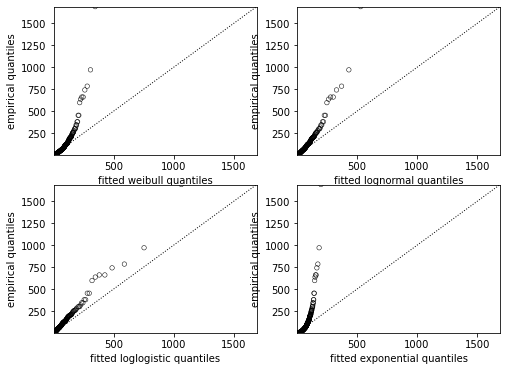

In [184]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.reshape(4,)

for i, model in enumerate([WeibullFitter(), LogNormalFitter(), LogLogisticFitter(), ExponentialFitter()]):
    model.fit(records['RUNS_STANDING'] + 1,event_observed = ~records['IS_STANDING'])
    qq_plot(model, ax=axes[i])

interestingly, none of the parametric functions appear to fit these survival curves

We can try another cox model

In [190]:
cph_2 = CoxPHFitter()
cph_2.fit(subsequent_records[['RUNS_STANDING','NOT_STANDING'] + cox_features]
            ,duration_col = 'RUNS_STANDING'
            ,event_col = 'NOT_STANDING')
cph_2.print_summary()

<lifelines.CoxPHFitter: fitted with 1650 total observations, 218 right-censored observations>
             duration col = 'RUNS_STANDING'
                event col = 'NOT_STANDING'
      baseline estimation = breslow
   number of observations = 1650
number of events observed = 1432
   partial log-likelihood = -8953.30
         time fit was run = 2021-07-22 04:18:06 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
PREVIOUS_DAYS_STANDING_LOG                     0.12       1.12       0.04             0.05             0.19                 1.05                 1.20
DAYS_SINCE_FIRST_RECORD_LOG                   -0.06       0.94       0.04            -0.13             0.01                 0.88                 1.01
PREVIOUS_RUNS_STANDING_LOG                    -0.15       0.86       0.05            -0.26            -0.05                 0.77                 0.95
CUMULATIVE_RUNS_LOG                           -0.40       0.67       0.05            -0.50            -0.30                 0.61                 0.74
GAME_Celeste                                   0.54       1.71       0.33            -0.11             1.18                 0.90                 3.25
GAME_Crossy Road                              -0.67       0.51       0.43            -1.51             0.16                 0.22                 1.18
GAME_Cuphead                                   0.00       1.00       0.34            -0.66             0.66                 0.52                 1.94
GAME_Getting Over It With Bennett Foddy        0.76       2.14       0.35             0.07             1.45                 1.07                 4.28
GAME_Grand Theft Auto V                        0.46       1.58       0.38            -0.29             1.21                 0.75                 3.35
GAME_Hades                                     0.38       1.47       0.35            -0.31             1.07                 0.74                 2.93
GAME_Hollow Knight                             0.03       1.03       0.39            -0.75             0.80                 0.47                 2.22
GAME_Luigi's Mansion                           0.72       2.04       0.38            -0.02             1.45                 0.98                 4.27
GAME_Mario Kart 8                              0.72       2.05       0.34             0.05             1.39                 1.05                 4.01
GAME_Mario Kart Wii                            0.32       1.38       0.35            -0.36             1.00                 0.70                 2.73
GAME_Minecraft: Bedrock Edition                0.83       2.29       0.33             0.18             1.47                 1.20                 4.37
GAME_Minecraft: Java Edition                   0.49       1.64       0.37            -0.23             1.22                 0.79                 3.38
GAME_New Super Mario Bros. Wii                 0.06       1.06       0.38            -0.69             0.80                 0.50                 2.23
GAME_Outlast                                   0.44       1.55       0.39            -0.33             1.20                 0.72                 3.31
GAME_Portal                                    0.43       1.54       0.37            -0.30             1.16                 0.74                 3.18
GAME_Portal 2                                 -0.07       0.93       0.41            -0.88             0.73                 0.42                 2.07
GAME_Pou                                       0.03       1.03       0.45            -0.86             0.92                 0.42                 2.52
GAME_ROBLOX: Piggy                             0.24       1.27       0.34            -0.43             0.90                 0.65                 2.46
GAME_ROBLOX: Speed Run 

The survival model for runs is even better than the days version! That is good to know, but unfortunately it is hard to predict how many runs will happen in the future, so this does not help us make a concrete prediction. 

## 6. Putting it all together to predict future of records

Neither the RATIO_CUT distribution nor the survival model tells us how records will evolve in the future. They each give us only one piece of the puzzle

We have two ways to predict the evolution of records over time. One is to use a traditional time-series analysis, which we will try first. The other is to use out RATIO_CUT distribution and our survival model in tandem

### A. Time series model

In [191]:
def get_time_series_df(records):
    '''Formats a record dataframe for time series analysis
    
    Args:
        records (df): data to transform

    Returns:
        records in long df format, which data for every day
    '''

    time_series_df = records[['DATE','TIME','CATEGORY','GAME']].copy()
    time_series_df['DATE'] = pd.to_datetime(time_series_df['DATE'])

    current_records = time_series = time_series_df.groupby(['GAME','CATEGORY'])[['TIME']].min()
    current_records.loc[:,'DATE'] = pd.to_datetime(datetime.datetime.today().date())

    time_series_df = pd.concat([time_series_df, current_records.reset_index()])

    time_series = time_series_df.groupby(['GAME','CATEGORY']).apply(lambda x : x.drop_duplicates('DATE')
                                                                      .set_index('DATE')['TIME']
                                                                      .resample('1D')
                                                                      .ffill())
    return time_series

def autoreg_wrapper(series, days_out):
    '''Performs autoregression and returns predictions
    
    Args:
        series (series): series to perform autoreg on (grouped by game and category)
        days_out (int): number of days out to make predictions for

    Returns:
        Predictions of records by game/category
    '''
    predictions = {}
    
    grouped_series = series.groupby(['GAME','CATEGORY'])
    for name, group in grouped_series:
        group.index = group.index.droplevel(0).droplevel(0)
        
        model = AutoReg(group, 5, trend = 'n')
        # fit model
        model_fit = model.fit()
        
        # make prediction
        forecast = model_fit.forecast(days_out)[days_out-1]

        predictions[name] = max(0,forecast) #we know time can't go negative
        
    return predictions

In [193]:
time_series = get_time_series_df(records)
time_series_predictions = autoreg_wrapper(time_series, 500)

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

Autoregression is a simple time series method, which predicts future values by a weighted combination of previous values. Of course most of the time the future value will just be equal to the previous values, but the autoregressive model can understand that the record does drop sometimes and adjust its expectation to somewhere in the middle

### B. Simulation with survival model

Our other option is to use simulation to combine
- our temporal survival model
- the distribution function we created earlier for RATIO_CUT

Note that both the survival model and the RATIO_CUT model will be affected by the exact day that a record is broken. For efficiency reasons, we don't want to generate samples from distributions one by one for each simulation. So we will use a heuristic, and freeze the metrics in place currently

In [194]:
def get_simulation_predictions(subsequent_records
                               , cph
                               , cox_features
                               , days_out
                               , pdf = None):
    
    '''Performs the simulation method to make predictions
    
    Args:
        subsequent_records (df): records data with initial records filtered out (we can't use them)
        cph: cox model
        cox_features (list): list of features used by cox model
        days_out (int): number of days out to make predictions for
        pdf (series): optional series to use for RATIO_CUT simulation. Alternative to linear model

    Returns:
        predictions by game/category
    '''
    rng = np.random.default_rng()
    
    standing_records = subsequent_records[subsequent_records['IS_STANDING']]
    standing_records = standing_records.set_index(['GAME','CATEGORY'])
    
    survival_table = cph.predict_survival_function(standing_records[cox_features]
                                 ,times=range(0,days_out))
    
    survival_table.columns = standing_records.index

    #the standing records have a different distribution, since they are conditional upon standing up to now
    survival_table_standing = cph.predict_survival_function(standing_records[cox_features]
                                 ,times=range(0,days_out)
                                 , conditional_after = standing_records['DAYS_STANDING'])

    survival_table_standing.columns = standing_records.index

    #we will set the possibility of no record being broken in the time frame to the 99999 index
    survival_table_pdf = (survival_table.shift(1).fillna(1) - survival_table)
    survival_table_pdf.loc[99999, : ] = survival_table.loc[days_out-1,:]
    
    survival_table_standing_pdf = (survival_table_standing.shift(1).fillna(1) - survival_table_standing)[1:]
    survival_table_standing_pdf.loc[99999, : ] = survival_table_standing.loc[days_out -1,:]
    
    probability_broken = 1 - survival_table_standing_pdf.loc[99999, : ]
    
    if pdf is None:
        cut_model = train_cut_model(subsequent_records)
        #by the time the record is broken, it will have stood at least for DAYS_SINCE_FIRST_RECORD and DAYS_STANDING
        standing_records['DAYS_SINCE_FIRST_RECORD'] += standing_records['DAYS_STANDING'] 
        log_predictions, sd = get_cut_distributions(standing_records, cut_model)
    
    res = {}
    for col in survival_table.columns:
        start_draw = list(rng.choice(a = np.array(survival_table_standing_pdf.index), size = 1000, p = survival_table_standing_pdf[col]))
        additional_draws = list(rng.choice(a = np.array(survival_table_pdf.index), size = 100000, p = survival_table_pdf[col]))
        
        if pdf is None:
            log_prediction = log_predictions.loc[col]
            #unwinding the distribution draws, which we got in the formal of a log estimate and standard deviation
            percent_off_draws = list(np.exp(np.random.normal(size = days_out*100)*sd + log_prediction))
        else: 
            percent_off_draws = list(rng.choice(a = pdf.index, size = days_out*100, p = pdf.values/sum(pdf.values))) 

        i_res = []
        for draw in start_draw:
            fraction = 1
            while draw < days_out:
                draw += additional_draws.pop()
                fraction *= (1-percent_off_draws.pop())
            i_res.append([fraction])
            
        res[col] = np.mean(i_res)*standing_records.loc[col,'TIME']
        
    return res, probability_broken

simulation_predictions, probability_broken = get_simulation_predictions(subsequent_records, cph, cox_features, 500)
print(list(simulation_predictions.keys())[0],list(simulation_predictions.values())[0])

('Call of Duty: Black Ops Cold War Zombies', 'Die Maschine') 38.12732572874903


### C. Testing

Okay, interesting but... are these predictions accurate? Fortunately we don't have to rely entirely on speculation. We can run back the clock and test how the procedure would have performed based on information from many days ago. 

We should also see how well the models do compared to a naive way of predicting future records, holding them constant into the future. While this method is simple it has a strong mathematical advantage: for every record which is not broken, it will make a 100% accurate forecast

In [195]:
def do_test(df
            , days_out
            , use_pdf = False):
    '''Performs backtesting
    
    Args:
        df (df): dataframe of games data
        days_out (int): number of days out to make predictions for
        use_pdf (boolean): controls whether we use the pdf method for RATIO_CUT simulation

    Returns:
        Dataframe of predictions by naive/simulation/time series
    '''
    date = datetime.datetime.today() - pd.DateOffset(days = days_out)

    actual_records = df.groupby(['GAME','CATEGORY'])['TIME'].min()

    df = df[pd.to_datetime(df['DATE']) <= date]

    records = feature_engineering(df)

    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(records['RATIO_CUT'].dropna(), bins = 100)
    best_dist = getattr(st, best_fit_name)

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params) if use_pdf else None
    
    cph, cox_features, subsequent_records = fit_time_cox(records)
    simulation_predictions, probability_broken = get_simulation_predictions(subsequent_records
                                                                           ,cph
                                                                           ,cox_features
                                                                           ,days_out
                                                                           ,pdf
                                                                           )

    time_series = get_time_series_df(records)
    time_series_predictions = autoreg_wrapper(time_series, days_out)
    
    standing_records = records[records['IS_STANDING']].set_index(['GAME','CATEGORY'])['TIME']

    results = pd.merge(actual_records
                       , standing_records
                       , left_index = True
                       , right_index = True
                       , suffixes = ['_ACTUAL','_ORIGINAL'])
    
    results.loc[:,'SIM_PREDICTION'] = results.index.map(simulation_predictions)
    results.loc[:,'TS_PREDICTION'] = results.index.map(time_series_predictions)

    results.loc[:,'WAS_BROKEN'] = results['TIME_ACTUAL'] < results['TIME_ORIGINAL']
    results.loc[:,'SIM_PROBABILITY_BROKEN'] = results.index.map(probability_broken)

    return results


In [196]:
results = do_test(full_df, 500)
y_cols = ['TIME_ORIGINAL','SIM_PREDICTION','TS_PREDICTION']
mapes = np.round([mean_absolute_percentage_error(results['TIME_ACTUAL'],results[y_col])*100 for y_col in y_cols],2)
r2s = np.round([r2_score(results['TIME_ACTUAL'],results[y_col])*100 for y_col in y_cols],2)

summary = pd.DataFrame({'MAPE' : mapes,'r2' : r2s}, index = y_cols)

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zac

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:24

In [197]:
print(summary)

                 MAPE     r2
TIME_ORIGINAL    8.87  98.69
SIM_PREDICTION   8.18  98.85
TS_PREDICTION   12.82  98.38


We see that the simulation method improves on the naive model for this test set. Interestingly, the time series method performed predictions were actually worse than the naive model. Why was that?

In [198]:
results.head()

TIME_ACTUAL  TIME_ORIGINAL  SIM_PREDICTION  \
GAME    CATEGORY                                                             
Celeste Any%                       1589.194       1659.166     1620.879787   
        Clear_Celestial Resort      231.013        239.666      230.981154   
        Clear_Forsaken City          53.788         58.837       57.289652   
        Clear_Golden Ridge          133.824        148.631      143.000072   
        Clear_Old Site               93.874         97.580       93.850484   

                                TS_PREDICTION  WAS_BROKEN  \
GAME    CATEGORY                                            
Celeste Any%                       954.369005        True   
        Clear_Celestial Resort     218.013863        True   
        Clear_Forsaken City         52.821319        True   
        Clear_Golden Ridge         138.028950        True   
        Clear_Old Site              90.925603        True   

                                SIM_PROBABILITY_BROKEN  
GAME    CATEGORY                                        
Celeste Any%                                  0.437936  
        Clear_Celestial Resort                0.559418  
        Clear_Forsaken City                   0.442386  
        Clear_Golden Ridge                    0.527130  
        Clear_Old Site                        0.540181

We can see that the time series model was far too optimistic about records going down. It did not predict that progress would slow over time, like the simulation model did. In theory there might be Bayesian methods that can incorporate this particular kind of diminishing marginal returns, but it would require additional effort beyond the AutoReg package

Another aspect of the predictions was how records would be broken at all. Since that is a binary target variable, it can be analyzed with a ROC curve

C:\Users\Zach Rosenof\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning:

Pass fpr=[0.         0.         0.         0.04545455 0.04545455 0.09090909
 0.09090909 0.13636364 0.13636364 0.18181818 0.18181818 0.22727273
 0.22727273 0.27272727 0.27272727 0.31818182 0.31818182 0.36363636
 0.36363636 0.40909091 0.40909091 0.45454545 0.45454545 0.5
 0.5        0.59090909 0.59090909 0.68181818 0.68181818 0.81818182
 0.81818182 1.        ], tpr=[0.         0.01315789 0.32894737 0.32894737 0.34210526 0.34210526
 0.39473684 0.39473684 0.40789474 0.40789474 0.42105263 0.42105263
 0.47368421 0.47368421 0.48684211 0.48684211 0.51315789 0.51315789
 0.59210526 0.59210526 0.60526316 0.60526316 0.76315789 0.76315789
 0.86842105 0.86842105 0.88157895 0.88157895 0.93421053 0.93421053
 0.97368421 1.        ], roc_auc=0.7081339712918661 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



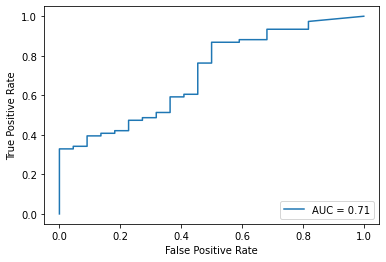

In [199]:
fpr, tpr, t = roc_curve(results['WAS_BROKEN'], results['SIM_PROBABILITY_BROKEN'])
auc = roc_auc_score(results['WAS_BROKEN'], results['SIM_PROBABILITY_BROKEN'])
display = RocCurveDisplay(fpr, tpr, auc)
display.plot()
plt.show()

71% is a reasonably good AUC, especially in the context of a chaotic system like speedrunning records 

Now that we have some confidence in our predictions, let's look at the ones we made for the future! They are set to 500 days out, and today is July 21st 2021, so the target date is December 3rd 2022

In [202]:
final = pd.DataFrame.from_dict(simulation_predictions, orient = 'index', columns = ['PREDICTED_FUTURE_RECORD'])
final.index = pd.MultiIndex.from_tuples(final.index)
final.index.names = ['Game','Category']

standing_records = subsequent_records[subsequent_records['IS_STANDING']]
standing_records = standing_records.set_index(['GAME','CATEGORY'])['CURRENT_RECORD']

probability_broken.name = 'PREDICTED_PROBABILITY_BROKEN'

final = pd.concat([final,standing_records, probability_broken], axis = 1)

pd.set_option('display.max_rows', 250)
final['PREDICTED_PROBABILITY_BROKEN'] = [str(np.round(x*100,1)) + '%' for x in probability_broken]

final

PREDICTED_FUTURE_RECORD  \
Call of Duty: Black Ops Cold War Zombies Die Maschine                                               38.127326   
                                         Firebase Z                                                 58.401676   
                                         Outbreak                                                   31.983824   
Celeste                                  100%                                                     5274.635305   
                                         All A-Sides                                              1862.417972   
                                         All C-Sides                                               248.790398   
                                         All Hearts                                               3000.279310   
                                         All Red Berries                                          2577.922179   
                                         Any%                                                     1354.397875   
                                         B-Side_Forsaken City                                       75.140281   
                                         B-Side_Mirror Temple                                      112.474256   
                                         B-Side_Old Site                                            77.710581   
                                         B-Side_Reflection                                         213.729988   
                                         C-Side_Forsaken City                                       16.638282   
                                         C-Side_Golden Ridge                                        23.768746   
                                         C-Side_Mirror Temple                                       18.633553   
                                         C-Side_Old Site                                            18.222752   
                                         C-Side_The Summit                                          36.694657   
                                         Clear_Celestial Resort                                    209.952252   
                                         Clear_Core                                                178.114536   
                                         Clear_Farewell                                            754.727739   
                                         Clear_Forsaken City                                        46.988390   
                                         Clear_Golden Ridge                                        119.476148   
                                         Clear_Mirror Temple                                       218.318497   
                                         Clear_Old Site                                             83.908693   
                                         Clear_Reflection                                          288.825217   
                                         Clear_The Summit                                          424.044462   
                                         Collectibles_Forsaken City                                 95.739747   
                                         True Ending                                              2454.342708   
Crossy Road                              100 Hops                                                   12.882053   
                                         25 Hops                                                     0.620871   
                                         50 Hops                                                     2.309645   
                                         Category Extensions: Times                                  0.029286   
                                         High Scores                                                 0.000980   
Cuphead                                  All Bosses                                                986.177082   
                  

## Conclusion 

Our simulation procedure forecasted speedrunning records more accurately than the naive alternative we examined. This suggests that innovation in speedrunning can be predicted, at least to some degree. We also saw that the longer a record has been standing the less likely it is to be broken in the future, which lends credence to the intuitive hypothesis that innovation begets innovation

Of course this is only a first pass at forecasting speedrunning records, and there are many possible areas for improvement. In particular the time series approach could use fine-tuning to more accurately reflect the dyanmics of speedrunning
